## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import imblearn

# from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

## Hyperparameters and Directories

In [2]:
data = 'Pokemon.csv'

SEED = None
ITERATIONS = 100000
LEARNING_RATE = 1000

## Data Loading and Pre-processing

### Import dataset

In [3]:
df = pd.read_csv('Pokemon.csv')

## Exploratory data analysis

In [4]:
print(f"Found {df.shape[0]} samples with {df.shape[1]} features")

Found 800 samples with 13 features


#### Let's preview the dataset

In [5]:
df.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

#### Now let's view the columns

In [6]:
col_names = df.columns

col_names

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

#### Check distribution of target_class column

In [7]:
df['Legendary'].value_counts()

Legendary
False    735
True      65
Name: count, dtype: int64

#### View summary of the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


#### Check of missing value

In [9]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Type 2 missing is normal, not all pokemon has secondary type

### Remove Mega Evolution Pokemon

In [10]:
df = df[~df['Name'].str.contains('Mega ')]

### Remove unused features

In [11]:
# df.drop(columns=['#', 'Name', 'Type 1', 'Type 2'],inplace=True)
df.drop(columns=['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation'],inplace=True)

df

Total  Legendary
0      318      False
1      405      False
2      525      False
4      309      False
5      405      False
..     ...        ...
794    600       True
795    600       True
797    600       True
798    680       True
799    600       True

[752 rows x 2 columns]

### Turn boolean to int

In [12]:
df['Legendary'] = df['Legendary'].astype(int)
df

Total  Legendary
0      318          0
1      405          0
2      525          0
4      309          0
5      405          0
..     ...        ...
794    600          1
795    600          1
797    600          1
798    680          1
799    600          1

[752 rows x 2 columns]

### Balance Data

In [13]:
# df = df[~((df['Legendary'] & (df['Total'] < 600)) | (~df['Legendary'] & (df['Total'] > 600)))]

### Declare feature vector and target variable

In [14]:
X = df.drop('Legendary', axis=1)  # Drop the target column from features
y = df['Legendary']  # Target column containing labels

### Split data into separate training and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [16]:
y_train.value_counts()

Legendary
0    554
1     47
Name: count, dtype: int64

## Training

### Function and Class

In [17]:
class LogisticRegression:
    # Class constructor
    def __init__(self, alpha=1, iteration=1500):
        self.w = None # Weights
        self.n = None # No. of samples
        self.b = 0
        self.X = None
        self.y = None
        # Define the learning rate
        self.alpha = alpha
        # Define the iteration number
        self.iteration = iteration
        self.losses = []

    def sigmoid(self, z):
        # print(f"z = {z}")
        return 1 / (1 + 1 / np.exp(z))

    # Class function to fit the data (find the appropiate value of w)
    def fit(self, X, y):
        # Feature scaling
        self.X = X / 100.0
        self.y = y

        # Number of samples & number of features (dimensions)
        self.n, d = X.shape
        print(X.shape)

        # Initialize w
        self.w = np.zeros(d)

        # Gradient Descent
        for i in range(self.iteration):
            print(f"Epoch {i+1}/{self.iteration}")
            # Decrease learning rate when overshot
            if not self.make_one_update():
                self.alpha *= 0.1

    def make_one_update(self):
        w_current = self.w
        b_current = self.b  

        # Compute gradients
        dw, db = self.compute_gradient(w_current, b_current)
        # print(dw, db)       
        step_w = (-1) * self.alpha * dw
        step_b = (-1) * self.alpha * db
        # print(step_b)

        # Update weights and bias
        w_update = w_current + step_w
        b_update = b_current + step_b

        current_loss = self.log_loss(w_current, b_current)
        update_loss = self.log_loss(w_update, b_update)

        self.losses.append(update_loss)
        
        if current_loss > update_loss:
            print("Loss decreases to ", update_loss)
            self.w = w_update
            self.b = b_update
            return True
        else:
            print("Loss increases to ", update_loss)
            return False

    def compute_gradient(self, w_current, b_current):
        z = np.dot(self.X, w_current) + b_current
        # Apply sigmoid function
        y_prob = self.sigmoid(z)

        # Compute gradients
        dw = (1 / self.n) * np.dot(self.X.transpose(), (y_prob - self.y))
        db = (1 / self.n) * np.sum(y_prob - self.y)

        return dw, db
    
    def log_loss(self, w, b):
        e = 1e-5
        z = np.dot(self.X, w) + b
        y_prob = self.sigmoid(z) + e
        loss = (-1 / self.n) * np.sum(self.y * np.log(y_prob)           # if y = 1
                              + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
        return loss

    def predict(self, X):
        # Feature scaling
        X = X / 100.0
        z = np.dot(X, self.w) + self.b
        y_pred = self.sigmoid(z)
        y_pred_class = [1 if i >= 0.5 else 0 for i in y_pred]
        return np.array(y_pred_class)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    def get_losses(self):
        return self.losses

    def probability(self, X):
        # Feature scaling
        X = X / 100.0
        z = np.dot(X, self.w) + self.b
        y_predicted = self.sigmoid(z)
        return y_predicted

### Prediction

In [18]:
h = LogisticRegression(alpha=LEARNING_RATE, iteration=ITERATIONS)
h.fit(X_train, y_train)
# y_pred = h.predict(X_test)

(601, 1)
Epoch 1/100000
Loss increases to  0.9003544706843609
Epoch 2/100000
Loss increases to  0.9003544706843609
Epoch 3/100000
Loss increases to  0.9003544706843609
Epoch 4/100000
Loss increases to  0.8006918176498647
Epoch 5/100000
Loss decreases to  0.4807587959742183
Epoch 6/100000
Loss decreases to  0.41851907626215423
Epoch 7/100000
Loss decreases to  0.39395478701850406
Epoch 8/100000
Loss decreases to  0.382275264722397
Epoch 9/100000
Loss decreases to  0.3760538898350364
Epoch 10/100000
Loss decreases to  0.3724676297623907
Epoch 11/100000
Loss decreases to  0.3702666715912661
Epoch 12/100000
Loss decreases to  0.36883800328077937
Epoch 13/100000
Loss decreases to  0.3678584212458209
Epoch 14/100000
Loss decreases to  0.3671482755189887
Epoch 15/100000
Loss decreases to  0.3666036707228637
Epoch 16/100000
Loss decreases to  0.3661626716355719
Epoch 17/100000
Loss decreases to  0.36578747733031636
Epoch 18/100000
Loss decreases to  0.3654545866865174
Epoch 19/100000
Loss decr

/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_6096/1581627357.py:17: RuntimeWarning: divide by zero encountered in divide
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_6096/1581627357.py:17: RuntimeWarning: divide by zero encountered in divide
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_6096/1581627357.py:17: RuntimeWarning: overflow encountered in divide
  return 1 / (1 + 1 / np.exp(z))


Loss decreases to  0.2991186005972033
Epoch 345/100000
Loss decreases to  0.29895821166737074
Epoch 346/100000
Loss decreases to  0.29879803764145835
Epoch 347/100000
Loss decreases to  0.29863807815289595
Epoch 348/100000
Loss decreases to  0.2984783328357348
Epoch 349/100000
Loss decreases to  0.2983188013246469
Epoch 350/100000
Loss decreases to  0.2981594832549243
Epoch 351/100000
Loss decreases to  0.298000378262479
Epoch 352/100000
Loss decreases to  0.29784148598384186
Epoch 353/100000
Loss decreases to  0.2976828060561626
Epoch 354/100000
Loss decreases to  0.29752433811720885
Epoch 355/100000
Loss decreases to  0.29736608180536567
Epoch 356/100000
Loss decreases to  0.2972080367596351
Epoch 357/100000
Loss decreases to  0.2970502026196356
Epoch 358/100000
Loss decreases to  0.2968925790256013
Epoch 359/100000
Loss decreases to  0.2967351656183817
Epoch 360/100000
Loss decreases to  0.2965779620394408
Epoch 361/100000
Loss decreases to  0.29642096793085704
Epoch 362/100000
Loss

### Plot Loss Function

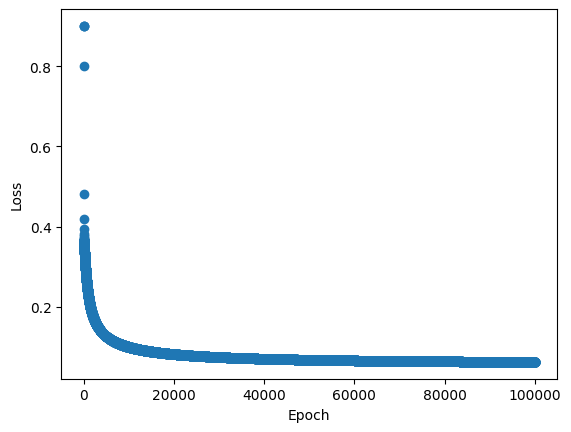

In [25]:
Epoch=pd.DataFrame(list(range(1,100001,1)))
Loss=pd.DataFrame(h.get_losses())
Loss_data=pd.concat([Epoch, Loss], axis=1)
Loss_data.columns=['Epoch','Loss']
plt.scatter(Loss_data['Epoch'], Loss_data['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluation

In [20]:
score = round(h.score(X_test, y_test)*100, 2)
print("The accuracy score we have achieved using Logistic Regression is: "+str(score)+" %")

The accuracy score we have achieved using Logistic Regression is: 94.7 %


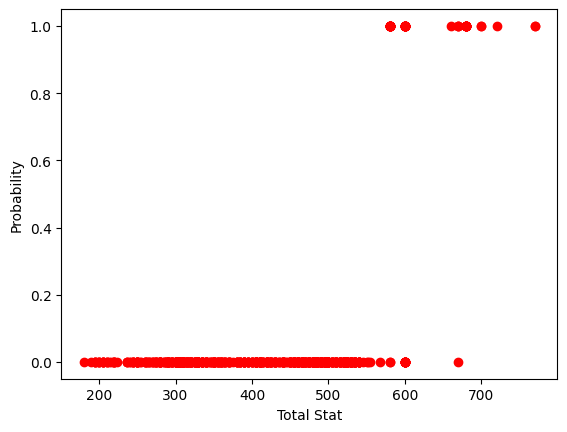

In [21]:
plt.plot(X, y, 'ro')
plt.xlabel('Total Stat')
plt.ylabel('Probability')
plt.show()

In [22]:
h.w

array([4.8540897])

In [23]:
h.b

-28.512321655266703

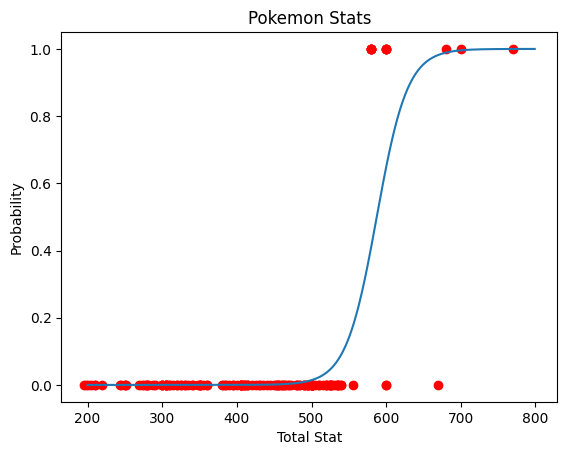

In [26]:
# Plot the probability curve
plt.plot(X_test, y_test, 'ro')
plt.plot(np.array([np.arange(start=200, stop=800, step=1)]).T, h.probability(np.array([np.arange(start=200, stop=800, step=1)]).T))
plt.xlabel('Total Stat')
plt.ylabel('Probability')
plt.title('Pokemon Stats')
plt.show()